As an international student in the U.S., I am interested in forecasting the exchange rate of USD to INR. To achieve this, I plan to perform a time series analysis to predict the value of INR against USD over time.

Getting the daily exchange rate data of USD to INR

In [80]:
import requests

f2 = open("alphavantageapikey.txt", "r")
api_key = f2.read()
f2.close()

url = 'https://www.alphavantage.co/query?function=FX_DAILY&from_symbol=USD&to_symbol=INR&apikey=' + api_key + '&outputsize=full&datatype=csv'
r = requests.get(url)
print(r.status_code)
with open('forex.csv', 'wb') as f:
  f.write(r.content)




200


The **ARIMA (AutoRegressive Integrated Moving Average)** model is a popular statistical method used for analyzing and forecasting time series data. It combines three key components:

**AutoRegressive (AR)**:

Represents the relationship between an observation and a specified number of lagged (past) observations.
Example: If the current value depends on the previous value(s), it’s captured by AR terms.

**Integrated (I)**:

Represents the differencing of observations to make the time series stationary (i.e., to remove trends or seasonality).
Example: Subtracting the previous value from the current value to remove trends.

**Moving Average** (MA):

Represents the relationship between an observation and the residual errors from a moving average model applied to lagged observations.
Example: If the current value depends on past forecast errors, it’s captured by MA terms.

**ARIMA Parameters**:
The model is denoted as ARIMA(p, d, q), where:

p: The number of lagged observations for the AR term.

d: The number of differences required to make the series stationary.

q: The size of the moving average window or lag of error terms.



In [81]:
import pandas as pd
df = pd.read_csv('forex.csv')
df.head()

,timestamp,open,high,low,close
0,2025-01-17,86.550,86.623,86.491,86.551
1,2025-01-16,86.349,86.599,86.349,86.550
2,2025-01-15,86.525,86.630,86.255,86.349
3,2025-01-14,86.626,86.675,86.445,86.515
4,2025-01-13,86.145,86.690,86.070,86.670


In [82]:
df = df.iloc[::-1]

In [83]:
df.shape

(2660, 5)

In [84]:
df.isna().sum()

,0
timestamp,0
open,0
high,0
low,0
close,0


In [85]:
df = df.reset_index(drop=True)
df

,timestamp,open,high,low,close
0,2014-11-07,61.390,61.620,61.340,61.400
1,2014-11-10,61.500,61.635,61.340,61.495
2,2014-11-11,61.530,61.555,61.505,61.508
3,2014-11-12,61.508,61.560,61.350,61.391
4,2014-11-13,61.368,61.623,61.350,61.565
...,...,...,...,...,...
2655,2025-01-13,86.145,86.690,86.070,86.670
2656,2025-01-14,86.626,86.675,86.445,86.515
2657,2025-01-15,86.525,86.630,86.255,86.349
2658,2025-01-16,86.349,86.599,86.349,86.550


I will be trying to predict the closing exchange rate of USD w.r.t INR.

In [86]:
split_point = int(len(df) * 0.8)
df_close = df[['close']].copy()
train_data = df_close.iloc[:split_point]
test_data = df_close.iloc[split_point:]

In [87]:
train_data

,close
0,61.400
1,61.495
2,61.508
3,61.391
4,61.565
...,...
2123,82.840
2124,82.710
2125,82.725
2126,82.754


In [88]:
test_data

,close
2128,82.548
2129,82.270
2130,82.070
2131,81.582
2132,81.617
...,...
2655,86.670
2656,86.515
2657,86.349
2658,86.550


The **Augmented Dickey-Fuller (ADF)** Test is a statistical test used to determine whether a time series is stationary or has a unit root. A time series is non-stationary if it exhibits a unit root, meaning the value at time t depends heavily on its previous value at time t-1. The ADF test checks for the presence of a unit root:

Null Hypothesis : The time series has a unit root (i.e., it is non-stationary).
Alternative Hypothesis : The time series does not have a unit root (i.e., it is stationary).
If the p-value is below a chosen significance level (e.g., 0.05), reject null hypothesis, concluding that the series is stationary.

In [89]:
from statsmodels.tsa.stattools import adfuller
print("ADF test p-value :", adfuller(train_data)[1])

ADF test p-value : 0.9287107415679234


Since p-value of ADF test is greater than 0.05, we can conclude that the series is non-stationary.

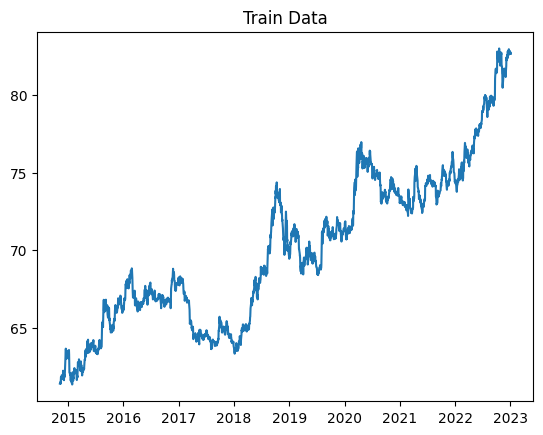

In [90]:
import matplotlib.pyplot as plt
df['timestamp'] = pd.to_datetime(df['timestamp'])
plt.plot(df['timestamp'].iloc[:split_point],train_data)
plt.title('Train Data')
plt.show()

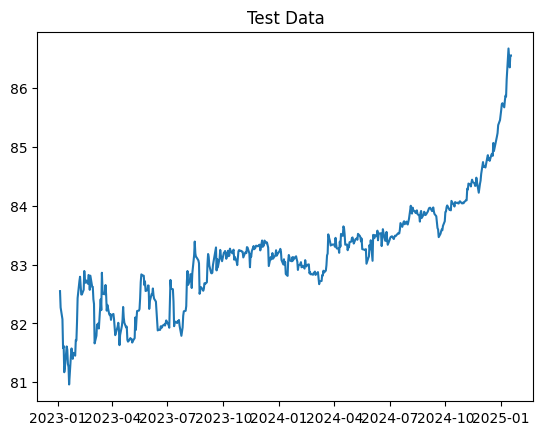

In [91]:
plt.plot(df['timestamp'].iloc[split_point:],test_data)
plt.title('Test Data')
plt.show()

**Autocorrelation Function (ACF)**: Measures the correlation between a time series and its lagged values across different lags.

Use ACF to understand overall patterns and determine the MA order. (q term)

**Partial Autocorrelation Function (PACF**): Measures the correlation between a time series and its lagged values after removing the effects of intermediate lags.

Use PACF to understand direct relationships and determine the AR order. (p term)

In [92]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Plotting the time series data showing the variation of exchange rate of USD w.r.t INR.

In [93]:
train_data_time = df['timestamp'].iloc[:split_point]
test_data_time = df['timestamp'].iloc[split_point:]

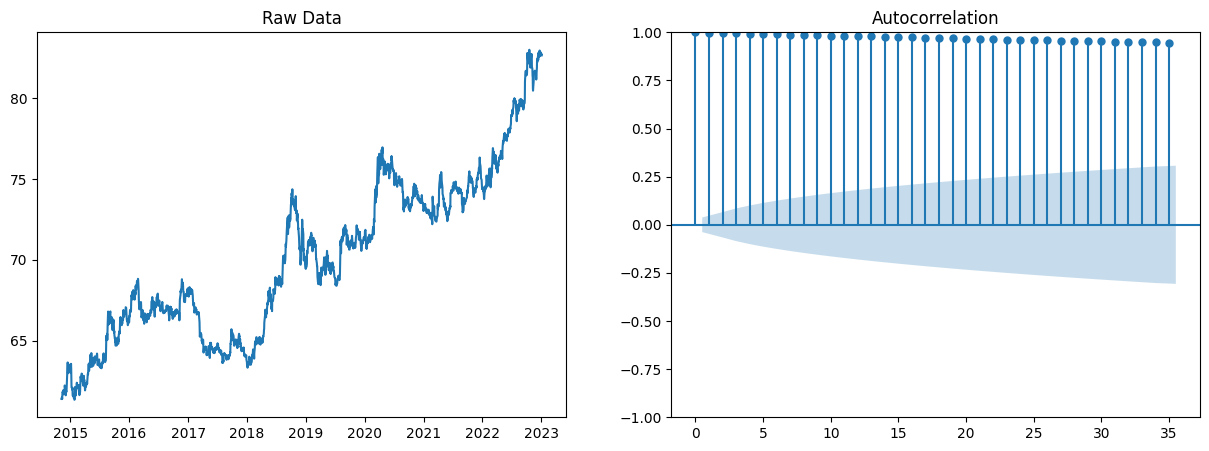

In [94]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.plot(train_data_time,train_data)
ax1.set_title('Raw Data')
plot_acf(df_close, ax=ax2)
plt.show()

To deal with non stationary, we apply differencing to the time series data.

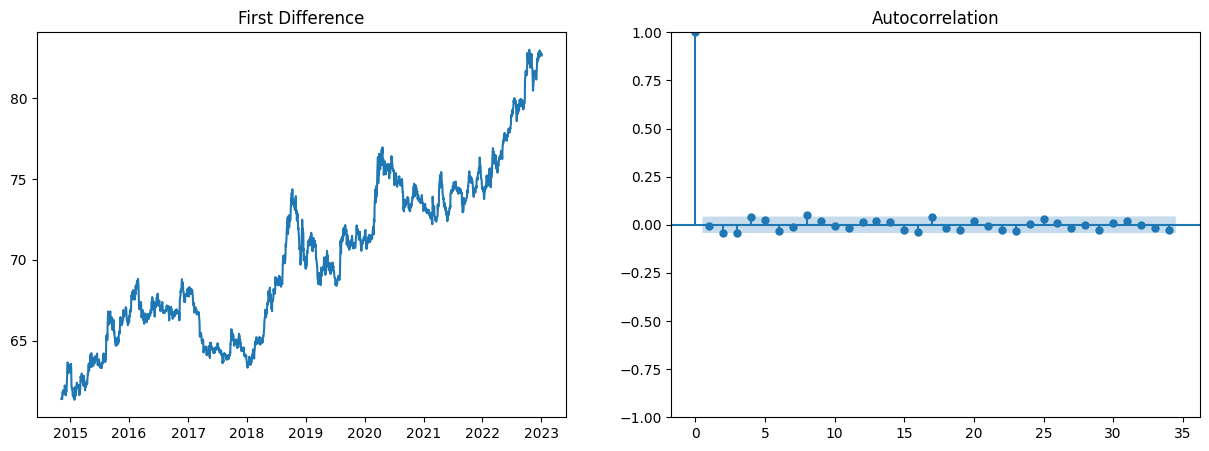

In [95]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.plot(train_data_time,train_data)
ax1.set_title('First Difference')
plot_acf(train_data.diff().dropna(), ax=ax2)
plt.show()

After applying differencing for a second time, we can see the correlation between the terms increased. So we take the differencing order to be 1. Therefore, d=1. From the first difference acf plot we can see that the second lag term is slightly above the threshold so we can choose the MA term q=2.

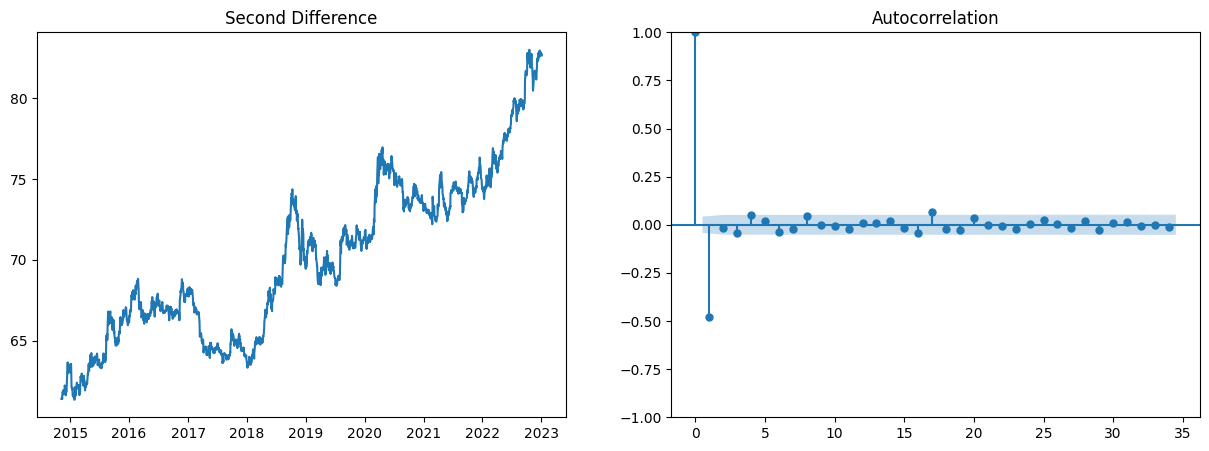

In [96]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.plot(train_data_time,train_data)
ax1.set_title('Second Difference')
plot_acf(train_data.diff().diff().dropna(), ax=ax2)
plt.show()

We can also determine the differencing order using the pmdarima module.

In [97]:
pip install pmdarima

In [98]:
from pmdarima.arima import ndiffs
print('Suggested diffencing order:', ndiffs(train_data, test='adf'))

Suggested diffencing order: 1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

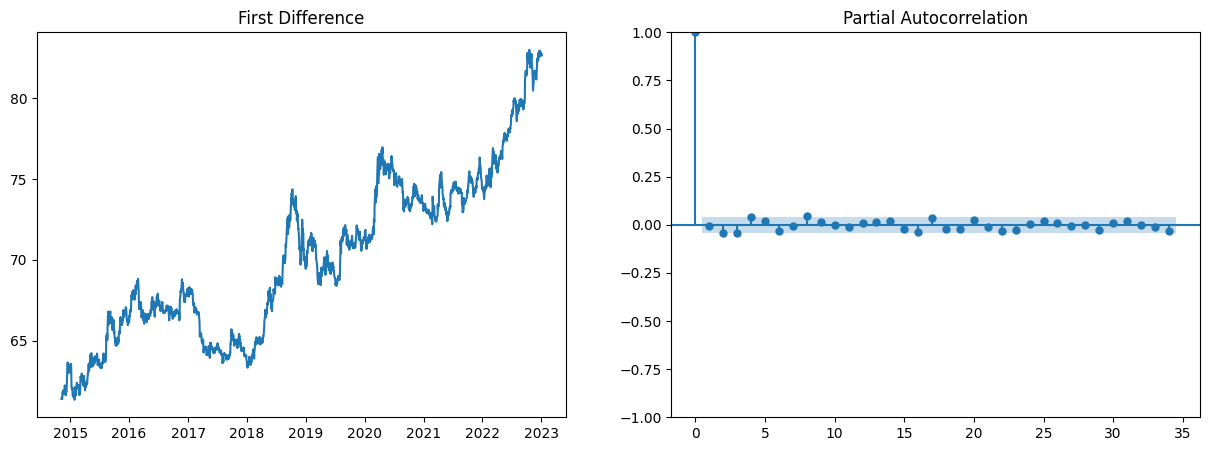

In [99]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.plot(train_data_time,train_data)
ax1.set_title('First Difference')

plot_pacf(train_data.diff().dropna(), ax=ax2)
plt.show()

Looking the pacf plot, we can see that the lag term number 2 or 3 is slightly greater that the threshold. So we can choose p=2 for our ARIMA model.

**Chosen ARIMA model**

In [100]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data, order=(2,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 2128
Model:                 ARIMA(2, 1, 2)   Log Likelihood                  -5.029
Date:                Sun, 19 Jan 2025   AIC                             20.059
Time:                        05:45:41   BIC                             48.371
Sample:                             0   HQIC                            30.422
                               - 2128                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1142      0.055      2.078      0.038       0.006       0.222
ar.L2         -0.8894      0.057    -15.683      0.000      -1.000      -0.778
ma.L1         -0.0991      0.062     -1.591      0.1

Forecasting the test data based on the model created using the train data.

In [101]:
fc = model_fit.get_forecast(steps=len(test_data), alpha=0.05)
print(fc.predicted_mean)

2128    82.628021
2129    82.639878
2130    82.672341
2131    82.665505
2132    82.635852
          ...    
2655    82.652225
2656    82.652225
2657    82.652225
2658    82.652225
2659    82.652225
Name: predicted_mean, Length: 532, dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Confidence Interval for the forecasted values.

In [102]:
conf = fc.conf_int()
print(conf)

      lower close  upper close
2128    82.152665    83.103377
2129    81.962529    83.317227
2130    81.851075    83.493607
2131    81.726158    83.604852
2132    81.584988    83.686717
...           ...          ...
2655    71.881157    93.423294
2656    71.870963    93.433488
2657    71.860778    93.443672
2658    71.850604    93.453847
2659    71.840438    93.464012

[532 rows x 2 columns]


In [103]:
fc = pd.Series(fc.predicted_mean, index = test_data.index)

lower = pd.Series(conf['lower close'], index = test_data.index)
upper = pd.Series(conf['upper close'], index = test_data.index)

Plotting the forecasted values vs the actual values. Also showing the confidence interval which shows that the actual values are within the forecasted confidence interval.

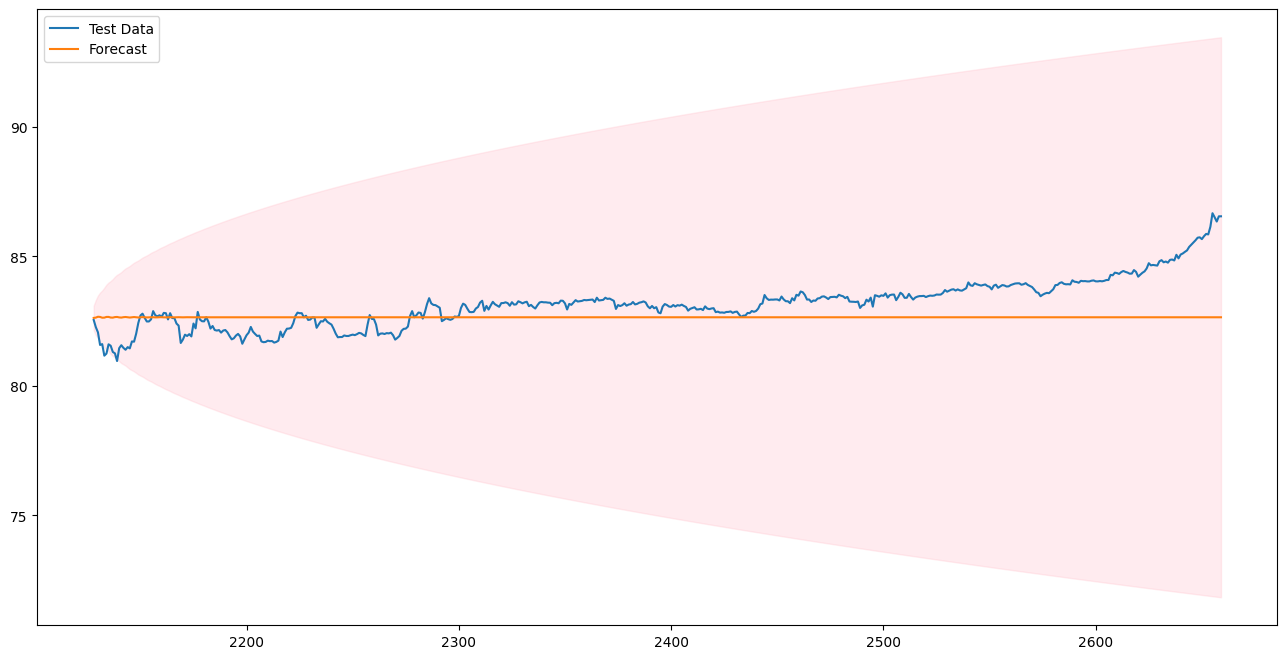

In [104]:
plt.figure(figsize=(16, 8))
plt.plot(test_data, label='Test Data')
plt.plot(fc, label='Forecast')
plt.fill_between(lower.index, lower, upper, color='pink', alpha=0.3)
plt.legend()
plt.show()


Comparison of actual test data with the predicted test data

Based on the plot above, we can observe that while the ARIMA model serves as a useful baseline for predicting time-dependent values, its accuracy still leaves room for improvement. The actual values are around 86, while the predicted mean hovers around 82. However, when considering the upper limit of the confidence interval, which is 92, the actual value falls within the predicted range. This suggests that, for a rough estimation of future values, the ARIMA model can be utilized effectively, taking into account not just the predicted mean but also the confidence interval bounds.

That being said, for more precise forecasting, a more advanced and accurate prediction model should be explored. This will be the focus of the next phase of the project, as we aim to enhance the prediction's reliability and accuracy.

In [105]:
from sklearn.metrics import mean_squared_error

# Generate predictions for the test data
start_index = split_point
end_index = df_close.index[-1]
print(start_index, end_index)
predictions = model_fit.predict(start = start_index, end = end_index)

# Evaluate the model
mse = mean_squared_error(test_data, predictions)
print(f"Mean Squared Error: {mse}")

2128 2659
Mean Squared Error: 1.1108653990403932


The selection of the parameters p, d, and q for the ARIMA model can be automated using the auto_arima function from the pmdarima library. This approach simplifies the process by automatically identifying the optimal parameters based on the data.

Now, we will try to predict the foreign exchange rate of USD in terms of INR for the next 60 days.


auto_arima uses SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors) because it is a more generalized and flexible model compared to the classic ARIMA. While ARIMA is designed for non-seasonal time series data, SARIMAX can handle both seasonal and non-seasonal components in the time series, along with the ability to include exogenous variables.

In [106]:
from pmdarima import auto_arima
model = auto_arima(df_close, seasonal=False, trace=True,
                   error_action='ignore', suppress_warnings=True)

print(model.summary())

Performing stepwise search to minimize aic


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-373.212, Time=14.51 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-361.296, Time=1.20 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-359.523, Time=0.82 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-359.543, Time=2.22 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-358.638, Time=0.39 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-360.701, Time=7.20 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-361.114, Time=6.68 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-373.905, Time=5.66 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-364.363, Time=3.71 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-371.943, Time=8.58 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-372.158, Time=6.05 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-373.887, Time=6.76 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-365.218, Time=2.83 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-370.127, Time=9.43 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0]             : AIC=-370.797, Time=1.86 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0] intercept
Total fit time: 77.969 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2660
Model:               SARIMAX(3, 1, 2)   Log Likelihood                 193.953
Date:                Sun, 19 Jan 2025   AIC                           -373.905
Time:                        05:47:00   BIC                           -332.705
Sample:                             0   HQIC                          -358.994
                               - 2660                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0176      0.008      2.203      0.028       0.002

In [107]:
forecast_steps = 60
forecast_values, conf_int = model.predict(n_periods=forecast_steps, return_conf_int=True)
print(conf_int)

[[86.12632623 87.00808755]
 [85.92594234 87.16640248]
 [85.79883084 87.29824067]
 [85.73007182 87.43797822]
 [85.64965833 87.55438325]
 [85.54302774 87.63578811]
 [85.46061141 87.71819172]
 [85.41570634 87.81900949]
 [85.36384691 87.90966628]
 [85.28712239 87.97462535]
 [85.22099714 88.03947908]
 [85.18322823 88.12124639]
 [85.14403612 88.19927622]
 [85.08452458 88.25747234]
 [85.0283663  88.31325639]
 [84.99372853 88.38281009]
 [84.96135476 88.45242423]
 [84.91333569 88.5069488 ]
 [84.86458027 88.55742856]
 [84.83183733 88.61841736]
 [84.80344215 88.68161758]
 [84.76354848 88.73364769]
 [84.72075535 88.78080301]
 [84.68954983 88.83555264]
 [84.66361424 88.89356076]
 [84.62961923 88.94357084]
 [84.59178348 88.9885108 ]
 [84.56205625 89.03862609]
 [84.53774665 89.09232236]
 [84.50809844 89.14051312]
 [84.47442711 89.1838692 ]
 [84.4462021  89.2304965 ]
 [84.42306743 89.28057799]
 [84.39666077 89.32705057]
 [84.36649215 89.36917915]
 [84.33979319 89.41314778]
 [84.31760024 89.46019157]
 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [112]:
start_value = 2659
fc_auto = pd.Series(forecast_values, index = pd.Index(range(start_value, start_value + 60)))

lower = pd.Series(conf_int[:,0], index = pd.Index(range(start_value, start_value + 60)))
upper = pd.Series(conf_int[:,1], index = pd.Index(range(start_value, start_value + 60)))

start_date = '2025-01-18'

date_series = pd.date_range(start=start_date, periods=60, freq='D')
print(date_series)

DatetimeIndex(['2025-01-18', '2025-01-19', '2025-01-20', '2025-01-21',
               '2025-01-22', '2025-01-23', '2025-01-24', '2025-01-25',
               '2025-01-26', '2025-01-27', '2025-01-28', '2025-01-29',
               '2025-01-30', '2025-01-31', '2025-02-01', '2025-02-02',
               '2025-02-03', '2025-02-04', '2025-02-05', '2025-02-06',
               '2025-02-07', '2025-02-08', '2025-02-09', '2025-02-10',
               '2025-02-11', '2025-02-12', '2025-02-13', '2025-02-14',
               '2025-02-15', '2025-02-16', '2025-02-17', '2025-02-18',
               '2025-02-19', '2025-02-20', '2025-02-21', '2025-02-22',
               '2025-02-23', '2025-02-24', '2025-02-25', '2025-02-26',
               '2025-02-27', '2025-02-28', '2025-03-01', '2025-03-02',
               '2025-03-03', '2025-03-04', '2025-03-05', '2025-03-06',
               '2025-03-07', '2025-03-08', '2025-03-09', '2025-03-10',
               '2025-03-11', '2025-03-12', '2025-03-13', '2025-03-14',
      

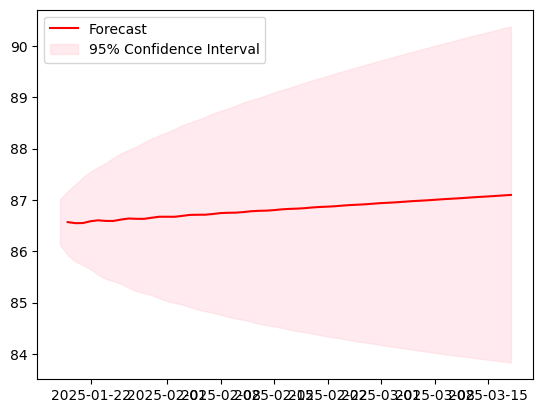

In [113]:
# plt.plot(df['timestamp'],df_close, label='Data')
plt.plot(date_series, fc_auto, label='Forecast', color='red')

# Plot the confidence intervals
plt.fill_between(date_series, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')

plt.legend()
plt.show()

Forecasted foreign exchange rate for the next 60 days.

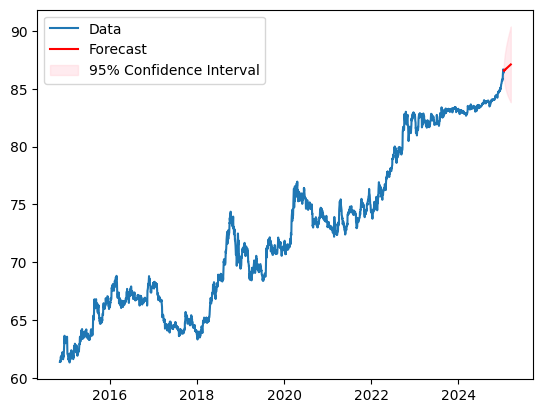

In [115]:
plt.plot(df['timestamp'],df_close, label='Data')
plt.plot(date_series, fc_auto, label='Forecast', color='red')
start_date = pd.to_datetime('2025-01-01')
end_date = pd.to_datetime('2025-03-18')

# Plot the confidence intervals
plt.fill_between(date_series, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')

plt.legend()
plt.show()

In the plot above the red line shows the forecasted values.

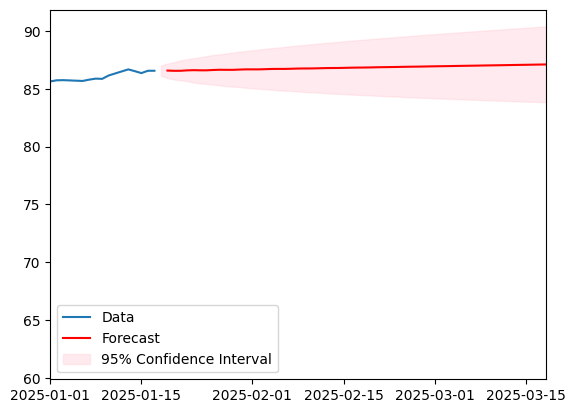

In [116]:
plt.plot(df['timestamp'],df_close, label='Data')
plt.plot(date_series, fc_auto, label='Forecast', color='red')
start_date = pd.to_datetime('2025-01-01')
end_date = pd.to_datetime('2025-03-18')

# Zoom in on the specific date range
plt.xlim(start_date, end_date)
# Plot the confidence intervals
plt.fill_between(date_series, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')

plt.legend()
plt.show()

Zoomed in version of the forecasted value.